In [149]:
import requests as req
import pandas as pd
import json
import numpy as np
import pydash as _
# Please make sure your python version is 3.6 or lower
# https://github.com/tweepy/tweepy/issues/1017
import tweepy

## Gather

Saving udacity provided dataset into the `tw_arch`

In [150]:
tw_arch = pd.read_csv("twitter-archive-enhanced.csv")
tw_arch.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In this part, I am going to be downloading and saving to disk `image-predictions.tsv` data from Udacity provided URL

In [151]:
# Download file
image_predictions = req.get(
    "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
).text

In [152]:
# write to disk
with open("image-predictions.tsv", "w") as f:
    f.write(image_predictions)

In [153]:
# load date to DataFrame
img_predictions = pd.read_csv("image-predictions.tsv", sep="\t")
img_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Loading data from twitter and storing them in `tweet_json.txt`

**Please set your credentials in `credentials.json` file to download data from twitter api**

In [154]:
# Load credentials an authorize
with open('credentials.json') as f:
    creds = json.load(f)

consumer_key = creds["consumer_key"]
consumer_secret = creds["consumer_secret"]
access_token = creds["access_token"]
access_secret = creds["access_secret"]
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit_notify=True, wait_on_rate_limit=True)

In [155]:
# store tweet ids into list
tweet_ids = list(img_predictions["tweet_id"])

tweet_data = []
tweet_errors = []
# TODO: REMOVE THIS
for idx, tweet_id in enumerate(tweet_ids[:1]):
    try:
        if idx % 50 == 0:
            print("Proccessed {}/{}".format(idx, len(tweet_ids)))
        t = api.get_status(tweet_id, tweet_mode='extended')
        tweet_data.append(
            _.pick(t, ["id", "retweet_count", "favorite_count"])
        )
    except Exception as err:
        print(err)
        tweet_errors.append((tweet_id, err))
        
print("\nDone: {} downloaded out of {}".format(len(tweet_data), len(tweet_ids)))

tweets_df = pd.DataFrame(tweet_data, columns = ['id', 'retweet_count', 'favorite_count'])
# TODO: REMOVE THIS
tweets_df.to_csv('tweet_json1.txt', encoding = 'utf-8')
print("\nTweets saved to tweet_json.txt")

print("\nFollowing tweet ids have failed")
print(tweet_errors)

Proccessed 0/2075

Done: 1 downloaded out of 2075

Tweets saved to tweet_json.txt

Following tweet ids have failed
[]


In [156]:
tweets_df = pd.read_csv("tweet_json.txt")
tweets_df.head()

,Unnamed: 0,id,retweet_count,favorite_count
0,0,666020888022790149,511,2556
1,1,666029285002620928,47,130
2,2,666033412701032449,44,125
3,3,666044226329800704,141,298
4,4,666049248165822465,40,109


# Assess

### Accessing  _`twitter-archive-enhanced.csv`_ dataset

In [157]:
tw_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- timestamp column should be date object
- there is lot of missing values for some columns

In [158]:
print("Duplicate count: {}".format(sum(tw_arch.duplicated())))

Duplicate count: 0


> `tw_arch` dataset seem to be duplicate free

In [159]:
tw_arch.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1296,707969809498152960,NaN,NaN,2016-03-10 16:42:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rufus. He's a Honeysuckle Firefox. Curly ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707969809...,11,10,Rufus,None,None,None,None
1098,736010884653420544,NaN,NaN,2016-05-27 01:47:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Right after you graduate vs when you remember ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/736010884...,10,10,None,None,None,None,None
1297,707776935007539200,NaN,NaN,2016-03-10 03:55:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sadie. She's a Bohemian Rhapsody. Rema...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707776935...,11,10,Sadie,None,None,None,None
2042,671538301157904385,NaN,NaN,2015-12-01 03:56:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Baxter. He's very calm. Hasn't eaten i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671538301...,8,10,Baxter,None,None,None,None
2266,667530908589760512,NaN,NaN,2015-11-20 02:32:25 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Naphaniel. He doesn't necessarily enjoy h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667530908...,10,10,Naphaniel,None,None,None,None
627,794983741416415232,NaN,NaN,2016-11-05 19:24:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Rizzy. She smiles a lot...,7.895309e+17,4.196984e+09,2016-10-21 18:16:44 +0000,https://twitter.com/dog_rates/status/789530877...,12,10,Rizzy,None,None,None,None
743,780459368902959104,NaN,NaN,2016-09-26 17:29:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Bear. Don't worry, he's not a real bea...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/780459368...,11,10,Bear,None,None,None,None
827,769212283578875904,NaN,NaN,2016-08-26 16:37:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is DonDon. He's way up but doesn't feel b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/769212283...,12,10,DonDon,None,None,None,None
903,758405701903519748,NaN,NaN,2016-07-27 20:56:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Odie. He falls asleep wherever he want...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758405701...,10,10,Odie,None,None,None,None
772,776477788987613185,NaN,NaN,2016-09-15 17:48:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Huck. He's addicted to caffeine. Hope ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776477788...,11,10,Huck,None,None,pupper,None


- lot of missing values in columns: `in_reply_to_status_id in_reply_to_user_id retweeted_status_id retweeted_status_user_id retweeted_status_timestamp`
- We could format date to `YYYY-MM-DD HH:MM:SS`
- missing dog names in `name` column

In [160]:
# Check for names that are probably incorect
tw_arch_names_to_nan = _.filter_(tw_arch.name.unique(), lambda x: len(x) < 4 and x.islower())
print("Most likely incorrect names: {}".format(tw_arch_names_to_nan))

Most likely incorrect names: ['a', 'not', 'one', 'mad', 'an', 'my', 'his', 'all', 'old', 'the', 'by']


- This names are probably entered incorrectly or were not intended as names. Futher I could add `None` to that list

In [161]:
# Add None to list of names to be replaced
tw_arch_names_to_nan.append('None')

In [162]:
tw_arch[["doggo","floofer","pupper","puppo"]].describe()

,doggo,floofer,pupper,puppo
count,2356,2356,2356,2356
unique,2,2,2,2
top,None,None,None,None
freq,2259,2346,2099,2326


- `doggo floofer pupper puppo` columns should be boolean or melt into one column

In [163]:
tw_arch.text[tw_arch.text.str.startswith('RT', na=False)].head()

19    RT @dog_rates: This is Canela. She attempted s...
32    RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...
36    RT @dog_rates: This is Lilly. She just paralle...
68    RT @dog_rates: This is Emmy. She was adopted t...
73    RT @dog_rates: Meet Shadow. In an attempt to r...
Name: text, dtype: object

- Unnecessary Retweet Observations. We will analyze only the tweet observations, not retweet observations.

In [164]:
# Null values in jpg_url
tw_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [165]:
img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- There are observations without images. The number of total observations is 2,356, but the number of the observation with image is 2,075.
- tweet_id should be string

### Accessing *`tweet_json.txt`*  dataset

In [166]:
tweets_df.head()

,Unnamed: 0,id,retweet_count,favorite_count
0,0,666020888022790149,511,2556
1,1,666029285002620928,47,130
2,2,666033412701032449,44,125
3,3,666044226329800704,141,298
4,4,666049248165822465,40,109


- `Unnamed: 0` should be droped

In [167]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 4 columns):
Unnamed: 0        2067 non-null int64
id                2067 non-null int64
retweet_count     2067 non-null int64
favorite_count    2067 non-null int64
dtypes: int64(4)
memory usage: 64.7 KB


> Value types are ok

In [168]:
tweets_df.describe()

,Unnamed: 0,id,retweet_count,favorite_count
count,2067.000000,2.067000e+03,2067.000000,2067.000000
mean,1033.000000,7.381015e+17,2847.682148,8497.542332
std,596.835823,6.769012e+16,4926.705597,12705.248775
min,0.000000,6.660209e+17,12.000000,0.000000
25%,516.500000,6.764355e+17,607.000000,1620.500000
50%,1033.000000,7.116948e+17,1343.000000,3749.000000
75%,1549.500000,7.931430e+17,3300.000000,10660.000000
max,2066.000000,8.924206e+17,84456.000000,163674.000000


> there seem to be `0` values in `favorite_count` column

In [169]:
tweets_df.duplicated().sum()

0

> No duplicates in this dataset

### Accessing *`image-predictions.tsv`*  dataset

In [170]:
img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [171]:
img_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


> Other than some rows are not dog related I can not see anything wrong with dataset so far

In [172]:
img_predictions.isnull().any().sum()

0

In [173]:
img_predictions.isna().any().sum()

0

In [174]:
img_predictions.duplicated().sum()

0

> No null, no Nan no duplicates. Looks good to me

### Access summary

#### Quality
*tw_arch*

<ul>
    <li><a style="text-decoration:none;" href="#1">timestamp column should be date object</a></li>
    <li><a style="text-decoration:none;" href="#2">We could format date to `YYYY-MM-DD HH:MM:SS`</a></li>
    <li><a style="text-decoration:none;" href="#3">lot of missing values in columns: `in_reply_to_status_id in_reply_to_user_id retweeted_status_id retweeted_status_user_id retweeted_status_timestamp`</a></li>
    <li><a style="text-decoration:none;" href="#4">`doggo floofer pupper puppo` columns should be boolean</a></li>
    <li><a style="text-decoration:none;" href="#5">missing dog names in `name` column</a></li>
    <li><a style="text-decoration:none;" href="#6">Some names are probably entered incorrectly or were not intended as names. I stored them in `tw_arch_names_to_nan`</a></li>
    <li><a style="text-decoration:none;" href="#7">Drop retweet observations</a></li>
    <li><a style="text-decoration:none;" href="#8">`rating_nominator` should be float datatype</a></li>
    <li><a style="text-decoration:none;" href="#19">Drop the observations without images.</a></li>
    <li><a style="text-decoration:none;" href="#19">tweet_id should be string</a></li>

    
    
</ul>

*any*
<ul>
  <li><a style="text-decoration:none;" href="#9">remove rows from `tw_arch` that are not in `tweets_df`</a></li>
</ul>

#### Tideness
*tweets_df*
<ul>
    <li><a style="text-decoration:none;" href="#10">remove `Unnamed: 0` column</a></li>
    <li><a style="text-decoration:none;" href="#11">rename `id` column to `tweet_id`</a></li>
</ul>


*tw_arch*
<ul>
  <li><a style="text-decoration:none;" href="#12">`doggo floofer pupper puppo`can be melt into one column</a></li>  
  <li><a style="text-decoration:none;" href="#13">we can merge all 3 dataset into one</a></li>
</ul>



## Clean

In [107]:
### Backup datasets
tw_arch_clean = tw_arch.copy()
img_predictions_clean = img_predictions.copy()
tweets_df_clean = tweets_df.copy()

### Quality

#### Define

<span id="1"></span>
<span id="2"></span>

1. Convert time column to date object
2. Set correct date format

#### Code

In [108]:
tw_arch_clean["timestamp"] = pd.to_datetime(tw_arch_clean["timestamp"])

#### Test

In [109]:
tw_arch_clean["timestamp"].head(1)

0   2017-08-01 16:23:56
Name: timestamp, dtype: datetime64[ns]

****

#### Define

<span id="3"></span>
3. Drop following columns `in_reply_to_status_id in_reply_to_user_id retweeted_status_id retweeted_status_user_id retweeted_status_timestamp`

#### Code

In [110]:
columns_to_drop_temp = ["in_reply_to_status_id",
                        "in_reply_to_user_id",
                        "retweeted_status_id",
                        "retweeted_status_user_id",
                        "retweeted_status_timestamp"]

tw_arch_clean.drop(columns_to_drop_temp, axis=1, inplace=True)

#### Test

In [111]:
# test if columns has been removed
for c in columns_to_drop_temp:
        assert(c not in list(tw_arch_clean))

****
#### Define
<span id="4"></span>
4. Convert `doggo floofer pupper puppo` to boolean

#### Code

In [112]:
# Set all values of "None" to False and rest to True
tw_arch_clean[["doggo", "floofer", "pupper", "puppo"]] = tw_arch_clean[["doggo", "floofer", "pupper", "puppo"]] != "None"

#### Test

In [113]:
tw_arch_clean[["doggo", "floofer", "pupper", "puppo"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
doggo      2356 non-null bool
floofer    2356 non-null bool
pupper     2356 non-null bool
puppo      2356 non-null bool
dtypes: bool(4)
memory usage: 9.3 KB


****
<span id="5"></span>
<span id="6"></span>
#### Define
5. Set dog names to Nan where name is "None"
6. Set dog names to Nan that weren't inteded as names

> All names to be renamed are stored in `tw_arch_names_to_nan`

**Code**

In [114]:
tw_arch_clean["name"].replace(tw_arch_names_to_nan, np.NaN, inplace=True)

#### Test

In [115]:
len(tw_arch_clean[tw_arch_clean["name"].isin(tw_arch_names_to_nan)])

0

****
<span id="7"></span>
#### Define
7. Drop retweet observations


**Code**

In [116]:
tw_arch_clean = tw_arch_clean.drop(index=tw_arch_clean.text[tw_arch_clean.text.str.startswith('RT', na=False)].index)

#### Test

In [117]:
tw_arch_clean.text[tw_arch_clean.text.str.startswith('RT', na=False)].head()

Series([], Name: text, dtype: object)

****
<span id="8"></span>
#### Define
8. Rating numerator should be float

**Code**

In [118]:
tw_arch_clean["rating_numerator"] = tw_arch_clean.rating_numerator.astype("float")

#### Test

In [119]:
tw_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2173 non-null int64
timestamp             2173 non-null datetime64[ns]
source                2173 non-null object
text                  2173 non-null object
expanded_urls         2115 non-null object
rating_numerator      2173 non-null float64
rating_denominator    2173 non-null int64
name                  1414 non-null object
doggo                 2173 non-null bool
floofer               2173 non-null bool
pupper                2173 non-null bool
puppo                 2173 non-null bool
dtypes: bool(4), datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 161.3+ KB


****
<span id="19"></span>
#### Define
8.1 tweet_id should be string

**Code**

In [120]:
# Drop the observations without images
tw_arch_clean["tweet_id"] = tw_arch_clean["tweet_id"].astype(str)
img_predictions_clean["tweet_id"] = img_predictions_clean["tweet_id"].astype(str)
tweets_df_clean["id"] = tweets_df_clean["id"].astype(str)

#### Test

In [121]:
tw_arch_clean.info()
img_predictions_clean.info()
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2173 non-null object
timestamp             2173 non-null datetime64[ns]
source                2173 non-null object
text                  2173 non-null object
expanded_urls         2115 non-null object
rating_numerator      2173 non-null float64
rating_denominator    2173 non-null int64
name                  1414 non-null object
doggo                 2173 non-null bool
floofer               2173 non-null bool
pupper                2173 non-null bool
puppo                 2173 non-null bool
dtypes: bool(4), datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 161.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2

****
<span id="9"></span>
#### Define
9. Remove rows from `tw_arch` that are not in `tweets_df`

**Code**



In [122]:
notin_temp = (~tw_arch_clean.tweet_id.isin(list(tweets_df_clean.id)))
tw_arch_clean = tw_arch_clean[~notin_temp]

#### Test

In [123]:
(~tw_arch_clean.tweet_id.isin(list(tweets_df_clean.id))).sum()

0

****
<span id="10"></span>
<span id="11"></span>
#### Define
10. Remove `Unnamed: 0` column from `tweets_df`
11. rename `id` column to `tweet_id`

**Code**

In [124]:
#Remove column
tweets_df_clean.drop(["Unnamed: 0"], axis=1, inplace=True)
#Rename column
tweets_df_clean.rename(columns={"id": "tweet_id"}, inplace=True)

#### Test

In [125]:
tweets_df_clean.head(1)

,tweet_id,retweet_count,favorite_count
0,666020888022790149,511,2556


****
<span id="12"></span>
#### Define
12. `doggo floofer pupper puppo`can be melt into one column


**Code**


In [126]:
columns_to_melt = ["doggo","floofer","pupper","puppo"]

# Add breed column
tw_arch_clean["breed"] = np.NaN

In [127]:
# Set breed value
for x in columns_to_melt:
    tw_arch_clean.loc[tw_arch_clean[x] == True, "breed"] = x

#### Test

In [128]:
test = tw_arch_clean.drop_duplicates("breed")
test[_.concat(columns_to_melt, ["breed"])]

,doggo,floofer,pupper,puppo,breed
0,False,False,False,False,NaN
9,True,False,False,False,doggo
12,False,False,False,True,puppo
29,False,False,True,False,pupper
46,False,True,False,False,floofer


In [129]:
# Drop columns we do not need
tw_arch_clean.drop(columns=columns_to_melt, axis=1, inplace=True)
list(tw_arch_clean.columns)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'breed']


****
<span id="13"></span>
#### Define
13. Merge all 3 dataset into one


**Code**



In [130]:
tweets_all = pd.merge(tw_arch_clean, tweets_df_clean, how="left", on="tweet_id")

In [131]:
tweets_all = pd.merge(tweets_all, img_predictions_clean, how="left", on="tweet_id")

#### Test

In [132]:
tweets_all.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,breed,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,NaN,8467,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False


## Storing, Analyzing, and Visualizing 

In [141]:
# Store into file
tweets_all.to_csv("twitter_archive_master.csv")

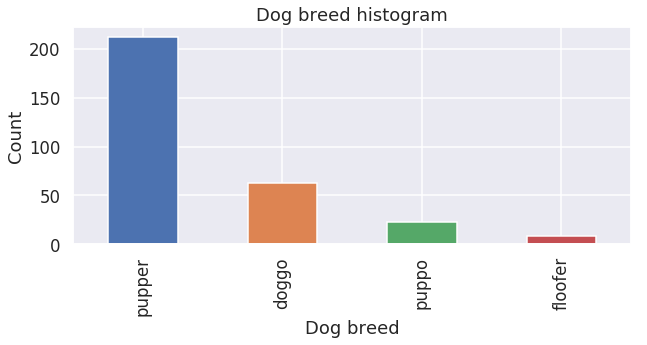

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ax = tweets_all["breed"].value_counts().plot(kind="bar", figsize=(10,4), title="Dog breed histogram");
ax.set_xlabel("Dog breed");
ax.set_ylabel("Count");

In [143]:

favorite_names = tweets_all[~tweets_all["name"].isna()].nlargest(10, 'favorite_count')

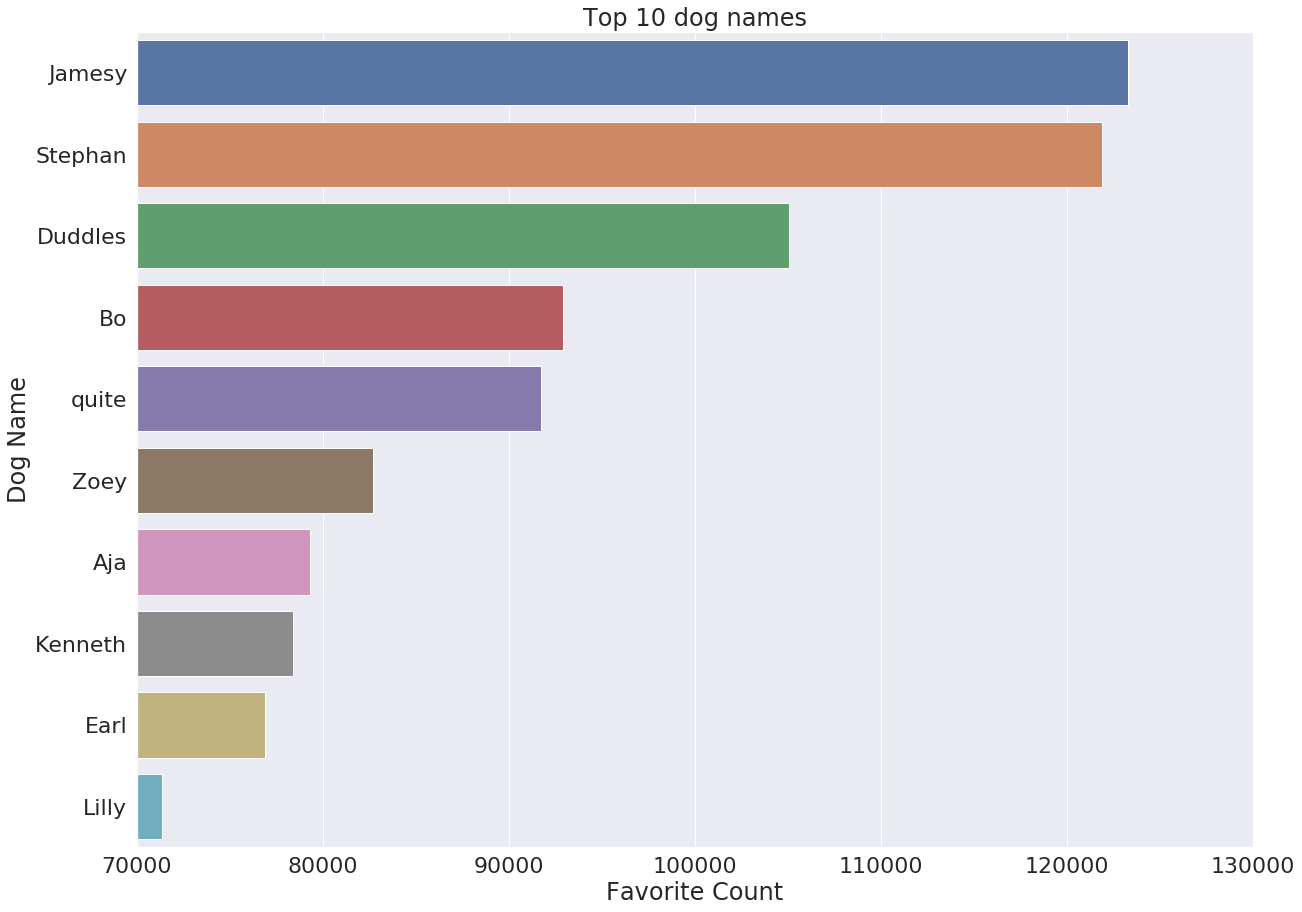

In [144]:
# sns.set(style="whitegrid");
sns.set(font_scale=2);
f, ax = plt.subplots(figsize=(20, 15));
ax = sns.barplot(y='name', x='favorite_count', data=favorite_names);

ax.set(xlim=(70000,130000), ylabel="Dog Name", xlabel="Favorite Count");
plt.title('Top 10 dog names');

> looks like most popular dog name is `Jamesy`

In [145]:
week_df = tweets_all[["timestamp", "favorite_count", "retweet_count"]]
week_df = week_df.resample('W-Mon', on='timestamp').sum().reset_index().sort_values(by='timestamp')



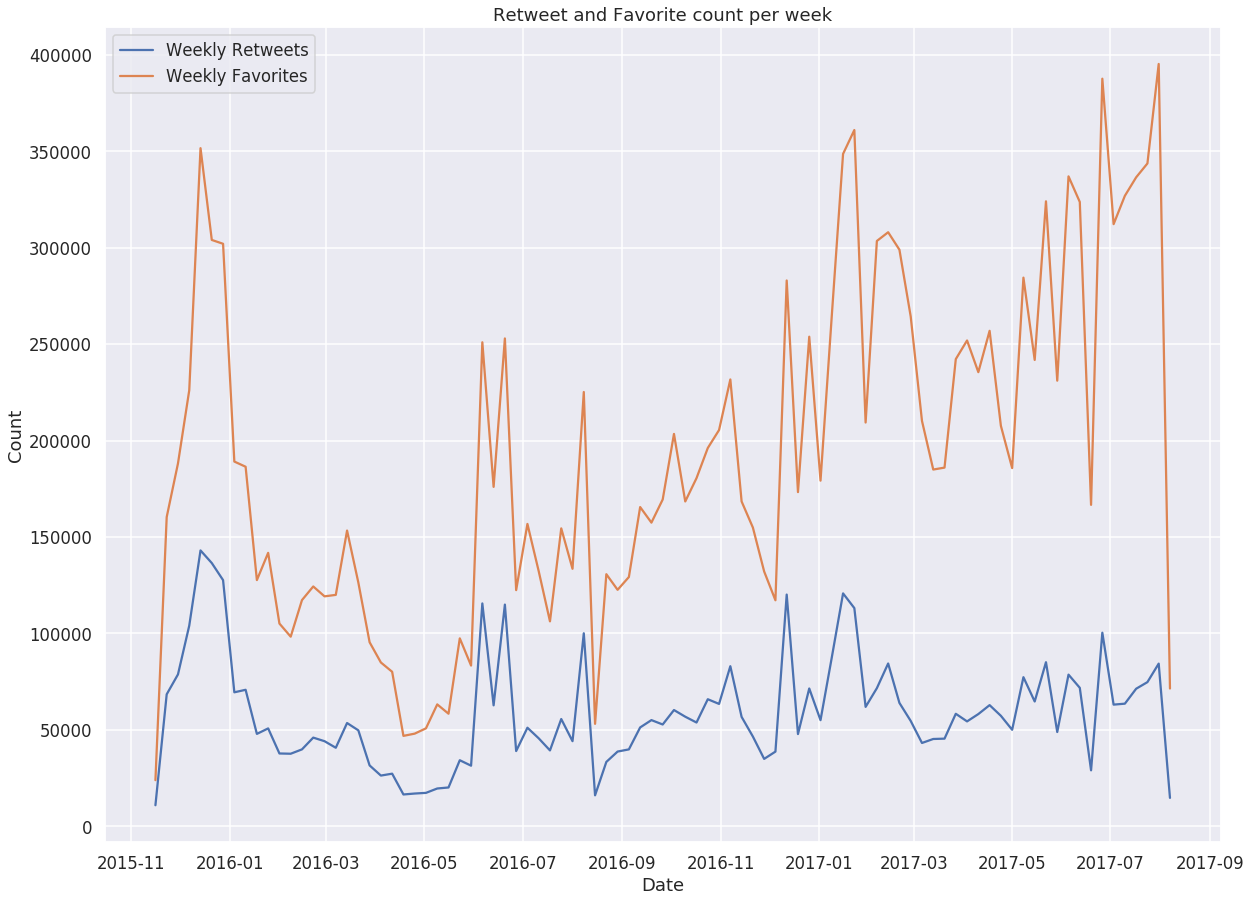

In [146]:

sns.set_context("talk")
f, ax = plt.subplots(figsize=(20, 15));

plt.plot(week_df.timestamp, week_df.retweet_count, label="Weekly Retweets")
plt.plot(week_df.timestamp, week_df.favorite_count, label="Weekly Favorites")
plt.title('Retweet and Favorite count per week');
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()

In [175]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'wrangle_act.ipynb'])

0